# 03 - Modeling

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import time

In [3]:
import sys
sys.path.append('../')

import src

In [4]:
plt.style.use('fivethirtyeight')

## Prepare data

In [5]:
df = pd.read_pickle('../data/training.pickle')

In [6]:
df.head(1)

,type,date,operation,lat,long,sex,age,ethnicity_self,ethnicity_officer,legislation,search_target,outcome,found_target,stripped,station,offense,success
observation_id,,,,,,,,,,,,,,,,,
d62c9e35-6293-45fc-aab6-706bdac1601e,Person search,2017-12-01 00:00:00+00:00,False,50.923411,-0.461108,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Offender given drugs possession warning,False,False,sussex,True,False


#### Drop metropolitan station from dataset

In [7]:
df = df[df.station!='metropolitan']

#### Select relevant columns

Requests will have the following format:
```
["observation_id": <string>,
 "Type": <string>,
 "Date": <string>,
 "Part of a policing operation": <boolean>,
 "Latitude": <float>,
 "Longitude": <float>,
 "Gender": <string>,
 "Age range": <string>,
 "Officer-defined ethnicity": <string>,
 "Legislation": <string>,
 "Object of search": <string>,
 "station": <string>]
 '''


In [8]:
supplied_columns = ['type', 'date', 'operation', 'lat', 'long', 'sex', 'age', 'ethnicity_officer', 'legislation', 'search_target', 'station']

In [9]:
X = df[supplied_columns]
y = df.success.values

### Processed Data Profile

In [11]:
profile = pp.ProfileReport(X, title='Training Data Profiling Report', explorative=False, minimal=False, pool_size=0, progress_bar=True)
profile.to_file('../reports/profiling/processed_profile.html')

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Pipeline

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, KBinsDiscretizer, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from category_encoders.target_encoder import TargetEncoder

import datetime as dt

### Preprocessing
#### Categorical Features

##### Assume searches with missing operation field did not happen as part of policing operation.

In [11]:
# df.operation = df.operation.fillna(False)
operation_imputer = SimpleImputer(strategy='constant', fill_value=False)

##### Replace missing legislations with 'unknown', then one-hot-encode column.

In [12]:
# df.legislation = df.legislation.astype('str').fillna('unknown').astype('category')
legislation_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
legislation_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
legislation_preprocessor = Pipeline(steps=[('legislation_imputer', legislation_imputer),
                                           ('legislation_encoder', legislation_encoder)])

##### One-hot-encode categorical features

In [13]:
# categoricals = X.select_dtypes(['category']).columns.tolist()
# categoricals.remove('legislation') # feature is already dealt with
# categoricals.remove('ethnicity_officer') # will not use this feature to avoid discrimination

categoricals = ['type', 'sex', 'age', 'search_target', 'station']
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

##### Combine categorical preprocessing steps

In [14]:
cat_preprocessor = ColumnTransformer(transformers=[('operation', operation_imputer, ['operation']),
                                                   ('legislation', legislation_preprocessor, ['legislation']),
                                                   ('cat_encoder', oh_encoder, categoricals)],
                                     remainder='drop')

#### Coordinate Features

##### Fill missing coordinate data with station means

In [15]:
#coordinate_dict = X.groupby('station')[['lat', 'long']].mean().fillna(X.mean()).to_dict()
coordinate_dict = \
{'lat': {'avon-and-somerset': 51.33301534853675,
  'bedfordshire': 51.99520005035238,
  'btp': 52.04498213727202,
  'cambridgeshire': 52.401295645642094,
  'cheshire': 53.27243561712015,
  'city-of-london': 51.515283227020134,
  'cleveland': 54.581267715107955,
  'cumbria': 54.53797709350655,
  'derbyshire': 53.01032026513161,
  'devon-and-cornwall': 50.53555175443321,
  'dorset': 50.71701186632197,
  'durham': 54.68330272246215,
  'dyfed-powys': 52.06194421428571,
  'essex': 51.72007429847026,
  'gloucestershire': 51.84977152248181,
  'greater-manchester': 53.47859898644197,
  'gwent': 51.60761234256556,
  'hampshire': 50.93652569163378,
  'hertfordshire': 51.76037049985289,
  'humberside': 53.48481868431375,
  'kent': 51.374468082246494,
  'lancashire': 53.78500562755108,
  'leicestershire': 52.65751631679406,
  'lincolnshire': 53.10683554523824,
  'merseyside': 53.436241618732225,
  'metropolitan': 52.515362957924715,
  'norfolk': 52.64006103976567,
  'north-wales': 53.17569351116731,
  'north-yorkshire': 54.041700087409595,
  'northamptonshire': 52.29232862938288,
  'northumbria': 54.98786282962144,
  'nottinghamshire': 52.98302869082842,
  'south-yorkshire': 52.515362957924715,
  'staffordshire': 52.87808759739836,
  'suffolk': 52.139193867362344,
  'surrey': 51.32796300224013,
  'sussex': 50.90980622282589,
  'thames-valley': 51.69650944703028,
  'warwickshire': 52.36734886374945,
  'west-mercia': 52.413887931124385,
  'west-yorkshire': 53.77299550808837,
  'wiltshire': 51.37899916477772},
 'long': {'avon-and-somerset': -2.6959433559473505,
  'bedfordshire': -0.4249400266868079,
  'btp': -0.7715286391456624,
  'cambridgeshire': -0.04725813646789005,
  'cheshire': -2.6387643686903965,
  'city-of-london': -0.0896220290722526,
  'cleveland': -1.2457966712230222,
  'cumbria': -3.136673164935065,
  'derbyshire': -1.4773875202376467,
  'devon-and-cornwall': -4.066873729177866,
  'dorset': -2.0917077684638166,
  'durham': -1.594638016918649,
  'dyfed-powys': -4.084971542857141,
  'essex': 0.538986324416861,
  'gloucestershire': -2.188883543046356,
  'greater-manchester': -2.248505129745514,
  'gwent': -3.0290781326530665,
  'hampshire': -1.1898053439685032,
  'hertfordshire': -0.2575871883632099,
  'humberside': -0.4107479908496726,
  'kent': 0.5604151309456336,
  'lancashire': -2.7154059084062276,
  'leicestershire': -1.1627258218159886,
  'lincolnshire': -0.35191183908730256,
  'merseyside': -2.9378837346396676,
  'metropolitan': -1.3420896304429029,
  'norfolk': 1.1136251113436533,
  'north-wales': -3.5303938708385822,
  'north-yorkshire': -1.1725005511775388,
  'northamptonshire': -0.8297320040567943,
  'northumbria': -1.5853070855440516,
  'nottinghamshire': -1.1530782153432024,
  'south-yorkshire': -1.3420896304429029,
  'staffordshire': -2.0221622171637286,
  'suffolk': 1.0365897135618494,
  'surrey': -0.4413027473143175,
  'sussex': -0.16365491495299755,
  'thames-valley': -0.9660928864365886,
  'warwickshire': -1.4958054560654521,
  'west-mercia': -2.3846032813072715,
  'west-yorkshire': -1.6477957410954118,
  'wiltshire': -1.9166443269398472}}

In [16]:
coordinate_imputer = FunctionTransformer(src.modeling.fill_coordinates_with_station_means)
coordinate_discretizer = KBinsDiscretizer(n_bins=50, encode='ordinal')
coordinate_categorizer = FunctionTransformer(src.modeling.grid_to_category)
coordinate_encoder = TargetEncoder(cols=None, handle_missing='value', handle_unknown='value')

In [17]:
coordinate_preprocessor = Pipeline(steps=[('fill_means', coordinate_imputer),
                                          ('discretize', coordinate_discretizer),
                                          ('categorizer', coordinate_categorizer),
                                          ('encode', coordinate_encoder),
                                         ])

#### Datetime features

In [18]:
date_extractor = FunctionTransformer(src.modeling.extract_datetime_features)
date_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
date_scaler = StandardScaler()

In [19]:
date_transformer = ColumnTransformer(transformers=[('oh_encoder', date_encoder, ['hour', 'weekday']),
                                                   ('scaler', date_scaler, ['daycount', 'sqrt_daycount']),
                                                  ])

In [20]:
date_preprocessor = Pipeline(steps=[('extract', date_extractor),
                                    ('transform', date_transformer)])

#### Combine all preprocessing steps

In [21]:
feature_preprocessor = FeatureUnion(transformer_list=[('categoricals', cat_preprocessor),
                                                      ('location', coordinate_preprocessor),
                                                      ('date', date_preprocessor)])

### Model Selection

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#### Train-Validation Split

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=X[['station']], shuffle=True)

#### Define Plain-Vanilla Models

In [27]:
# tree-based models
dtc = ('Decision Tree', DecisionTreeClassifier())
rfc = ('Random Forest', RandomForestClassifier())

# nonlinear regression models
lrc = ('Logistic Regression', LogisticRegression())
sgd = ('Stochastic Gradient', SGDClassifier(loss='log'))

# other classifiers
# svc = SVC() #too slow
# gbc = GradientBoostingClassifier() #too slow

# gradient boosting methods
abc = ('Ada Boost', AdaBoostClassifier()) #slow but okay
xgb = ('XG Boost', XGBClassifier()) #okay
lgbm = ('Light GBM', LGBMClassifier()) #fast
# cbc = ('Cat Boost', CatBoostClassifier(iterations=100)) #keeps crashing

In [29]:
classifiers = [dtc, rfc, lrc, sgd, abc, xgb, lgbm]

In [77]:
X_train.iloc[0:1]

,type,date,operation,lat,long,sex,age,ethnicity_officer,legislation,search_target,station
observation_id,,,,,,,,,,,
b85c7d69-2f90-42ba-b732-d7cdd91853e5,Person search,2019-09-02 14:13:00+00:00,False,51.669554,-0.41318,Male,18-24,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hertfordshire


In [81]:
import json

In [85]:
a = json.dumps(True)

In [79]:
src.evaluate.authorise_search(pipeline, X_train.iloc[0:1])[0]

True

In [45]:
##WEGg
pipeline = Pipeline(steps=[('preprocess', feature_preprocessor),
                               ('clf', lrc[1])],
                        verbose=False)
pipeline.fit(X_train, y_train)

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTA

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('categoricals',
                                                 ColumnTransformer(transformers=[('operation',
                                                                                  SimpleImputer(fill_value=False,
                                                                                                strategy='constant'),
                                                                                  ['operation']),
                                                                                 ('legislation',
                                                                                  Pipeline(steps=[('legislation_imputer',
                                                                                                   SimpleImputer(fill_value='unknown',
                                                                                                                 strategy='co

In [54]:
%%time
df_plain_models = pd.DataFrame(index=['Baseline']+[name for (name, clf) in classifiers],
                               columns=pd.MultiIndex.from_product([['train', 'val'], []]))

# evaluate baseline
df_plain_models.at['Baseline', ('train', 'time')] = 0

df_plain_models.at['Baseline', ('train', 'precision')] = precision_score(y_train, np.ones(y_train.shape))
df_plain_models.at['Baseline', ('val', 'precision')] = precision_score(y_val, np.ones(y_val.shape))

df_plain_models.at['Baseline', ('train', 'auroc')] = roc_auc_score(y_train, np.ones(y_train.shape))
df_plain_models.at['Baseline', ('val', 'auroc')] = roc_auc_score(y_val, np.ones(y_val.shape))
    
df_plain_models.at['Baseline', ('train', 'within_station')] = src.evaluate.within_station_discrepancy(np.ones(y_train.shape), y_train, X_train).max()
df_plain_models.at['Baseline', ('val', 'within_station')] = src.evaluate.within_station_discrepancy(np.ones(y_val.shape), y_val, X_val).max()

df_plain_models.at['Baseline', ('train', 'within_station_std')] = src.evaluate.within_station_discrepancy(np.ones(y_train.shape), y_train, X_train).std()
df_plain_models.at['Baseline', ('val', 'within_station_std')] = src.evaluate.within_station_discrepancy(np.ones(y_val.shape), y_val, X_val).std()
    
df_plain_models.at['Baseline', ('train', 'across_station')] = src.evaluate.across_station_discrepancy(np.ones(y_train.shape), y_train, X_train)
df_plain_models.at['Baseline', ('val', 'across_station')] = src.evaluate.across_station_discrepancy(np.ones(y_val.shape), y_val, X_val)
    
df_plain_models.at['Baseline', ('train', 'across_group')] = src.evaluate.across_subgroup_discrepancy(np.ones(y_train.shape), y_train, X_train)
df_plain_models.at['Baseline', ('val', 'across_group')] = src.evaluate.across_subgroup_discrepancy(np.ones(y_val.shape), y_val, X_val)

for name, clf in classifiers:
    # build pipeline
    pipeline = Pipeline(steps=[('preprocess', feature_preprocessor),
                               ('clf', clf)],
                        verbose=False)
    
    # train
    t = time.time()
    pipeline.fit(X_train, y_train)
    elapsed = time.time() - t
    df_plain_models.at[name, ('train', 'time')] = elapsed
    
    # predict
    authorised_train = src.evaluate.authorise_search(pipeline, X_train)
    authorised_val = src.evaluate.authorise_search(pipeline, X_val)
    pred_train = pipeline.predict(X_train)
    pred_val = pipeline.predict(X_val)
    
    # evaluate
    df_plain_models.at[name, ('train', 'precision')] = precision_score(y_train, pred_train)
    df_plain_models.at[name, ('val', 'precision')] = precision_score(y_val, pred_val)
    
    df_plain_models.at[name, ('train', 'auroc')] = roc_auc_score(y_train, pred_train)
    df_plain_models.at[name, ('val', 'auroc')] = roc_auc_score(y_val, pred_val)
    
    df_plain_models.at[name, ('train', 'within_station')] = src.evaluate.within_station_discrepancy(pred_train, y_train, X_train).max()
    df_plain_models.at[name, ('val', 'within_station')] = src.evaluate.within_station_discrepancy(pred_val, y_val, X_val).max()
    
    df_plain_models.at[name, ('train', 'within_station_std')] = src.evaluate.within_station_discrepancy(pred_train, y_train, X_train).std()
    df_plain_models.at[name, ('val', 'within_station_std')] = src.evaluate.within_station_discrepancy(pred_val, y_val, X_val).std()
    
    df_plain_models.at[name, ('train', 'across_station')] = src.evaluate.across_station_discrepancy(pred_train, y_train, X_train)
    df_plain_models.at[name, ('val', 'across_station')] = src.evaluate.across_station_discrepancy(pred_val, y_val, X_val)
    
    df_plain_models.at[name, ('train', 'across_group')] = src.evaluate.across_subgroup_discrepancy(pred_train, y_train, X_train)
    df_plain_models.at[name, ('val', 'across_group')] = src.evaluate.across_subgroup_discrepancy(pred_val, y_val, X_val)
    
    print('Trained {} in {}'.format(name, elapsed))
    
df_plain_models.to_pickle('../data/df_plain_models.pickle')

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Trained Decision Tree in 15.824686050415039


/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Trained Random Forest in 85.83330774307251


/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTA

Trained Logistic Regression in 18.302623510360718


/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Trained Stochastic Gradient in 7.496161699295044


/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Trained Ada Boost in 100.75494813919067


/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be r

[17:54:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Trained XG Boost in 64.17622017860413


/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Trained Light GBM in 8.862217426300049
CPU times: user 10min 52s, sys: 1min 17s, total: 12min 10s
Wall time: 9min 17s


In [71]:
df_plain_models['train']

,time,precision,auroc,within_station,within_station_std,across_station,across_group
Baseline,0.000000,0.201366,0.500000,0.273469,0.065433,0.358063,0.046824
Decision Tree,15.824686,0.996630,0.960822,0.076923,0.017838,0.018182,0.008511
Random Forest,85.833308,0.978921,0.967174,0.250000,0.055820,0.040423,0.026961
Logistic Regression,18.302624,0.532534,0.505554,1.000000,0.359431,1.000000,0.589041
Stochastic Gradient,7.496162,0.532880,0.504199,1.000000,0.394917,1.000000,0.750000
Ada Boost,100.754948,0.528802,0.504081,1.000000,0.387337,1.000000,0.558442
XG Boost,64.176220,0.701675,0.515870,1.000000,0.340864,0.400000,0.350575
Light GBM,8.862217,0.675994,0.504628,1.000000,0.382090,0.750000,0.800000


In [72]:
df_plain_models['val']

,precision,auroc,within_station,within_station_std,across_station,across_group
Baseline,0.201366,0.500000,0.216552,0.057785,0.365060,0.083333
Decision Tree,0.297680,0.559253,0.400000,0.108713,0.414035,0.411765
Random Forest,0.384603,0.538997,0.750000,0.203253,0.336043,0.500000
Logistic Regression,0.431138,0.503857,1.000000,0.393698,1.000000,0.500000
Stochastic Gradient,0.463291,0.503466,1.000000,0.379665,1.000000,0.666667
Ada Boost,0.461972,0.503100,1.000000,0.335291,1.000000,1.000000
XG Boost,0.431843,0.507081,1.000000,0.364872,0.585714,0.652778
Light GBM,0.441065,0.502112,1.000000,0.358968,1.000000,0.666667


<AxesSubplot:>

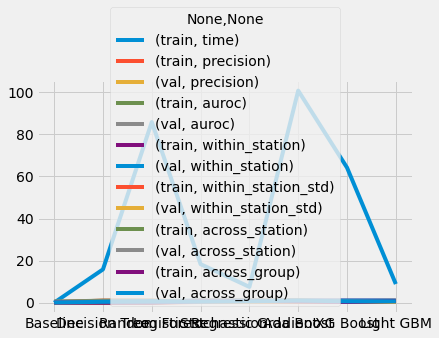

In [57]:
df_plain_models.plot()

In [26]:
pipeline = Pipeline(steps=[('preprocess', feature_preprocessor),
                           ('clf', cbc[1])],
                        verbose=True)
pipeline.fit(X_train, y_train)

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   5.5s
Learning rate set to 0.5
0:	learn: 0.5203100	total: 175ms	remaining: 17.3s
1:	learn: 0.4813107	total: 264ms	remaining: 12.9s
2:	learn: 0.4703295	total: 320ms	remaining: 10.3s
3:	learn: 0.4674993	total: 386ms	remaining: 9.27s
4:	learn: 0.4657250	total: 492ms	remaining: 9.35s
5:	learn: 0.4648003	total: 578ms	remaining: 9.05s
6:	learn: 0.4627423	total: 668ms	remaining: 8.88s
7:	learn: 0.4612158	total: 764ms	remaining: 8.78s
8:	learn: 0.4608525	total: 830ms	remaining: 8.4s
9:	learn: 0.4598281	total: 916ms	remaining: 8.24s
10:	learn: 0.4594051	total: 1.03s	remaining: 8.34s
11:	learn: 0.4588135	total: 1.11s	remaining: 8.16s
12:	learn: 0.4582233	total: 1.21s	remaining: 8.09s
13:	learn: 0.4579194	total: 1.29s	remaining: 7.96s
14:	learn: 0.4573831	total: 1.36s	remaining: 7.72s
15:	learn: 0.4568056	total: 1.44s	remaining: 7.55s
16:	learn: 0.4564929	total: 1.54s	remaining: 7.52s
17:	learn: 0.4562317	total: 1.63s	remaining: 7.4

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('categoricals',
                                                 ColumnTransformer(transformers=[('operation',
                                                                                  SimpleImputer(fill_value=False,
                                                                                                strategy='constant'),
                                                                                  ['operation']),
                                                                                 ('legislation',
                                                                                  Pipeline(steps=[('legislation_imputer',
                                                                                                   SimpleImputer(fill_value='unknown',
                                                                                                                 strategy='co

In [31]:
# construct & train pipeline
pipeline = Pipeline(steps=[('preprocess', feature_preprocessor),
                           ('clf', dtc)],
                        verbose=True)
pipeline.fit(X_train, y_train)

# predict
authorised_train = src.evaluate.authorise_search(pipeline, X_train)
authorised_val = src.evaluate.authorise_search(pipeline, X_val)
pred_train = pipeline.predict(X_train)
pred_val = pipeline.predict(X_val)

#
pred_train = src.evaluate.authorise_search(pipeline, X_train)
pred_val = src.evaluate.authorise_search(pipeline, X_val)



In [41]:
score_train = precision_score(y_train, pred_train)
score_val = precision_score(y_val, pred_val)

print(score_train, score_val)

0.914500870513708 0.29317029525797794


In [42]:
src.evaluate.calculate_subgroup_precisions(pred_train, y_train, X_train, grouping=['ethnicity', 'gender']).unstack()

gender,Female,Male
ethnicity,,
Asian,0.945736,0.896135
Black,0.974468,0.904176
Mixed,1.000000,0.926740
Other,0.957746,0.904437
White,0.966594,0.911802


In [43]:
src.evaluate.calculate_subgroup_precisions(pred_train, y_train, X_train, grouping=['station'])#.plot()#.unstack()

station
avon-and-somerset     0.911372
bedfordshire          0.911252
btp                   0.919149
cambridgeshire        0.926829
cheshire              0.961499
city-of-london        0.954103
cleveland             0.931818
cumbria               0.965318
derbyshire            0.941634
devon-and-cornwall    0.934146
dorset                0.859073
durham                0.922975
dyfed-powys           0.865672
essex                 0.908972
gloucestershire       0.918200
greater-manchester    0.938931
gwent                      NaN
hampshire             0.918990
hertfordshire         0.925000
humberside                 NaN
kent                  0.945070
lancashire            0.924312
leicestershire        0.958525
lincolnshire          0.950512
merseyside            0.939752
metropolitan               NaN
norfolk               0.889299
north-wales           0.921371
north-yorkshire       0.955224
northamptonshire      0.898119
northumbria           0.922276
nottinghamshire       0.929587


In [44]:
src.evaluate.within_station_discrepancy(pred_train, y_train, X_train).max()

0.35945945945945945

In [45]:
src.evaluate.across_station_discrepancy(pred_train, y_train, X_train)

0.1517229646252496

In [46]:
src.evaluate.across_subgroup_discrepancy(pred_train, y_train, X_train)

0.10386536944517488

In [47]:
src.evaluate.within_station_discrepancy(pred_val, y_val, X_val).max()

0.4123157248157248

In [48]:
src.evaluate.across_station_discrepancy(pred_val, y_val, X_val)

0.40460526315789475

In [49]:
src.evaluate.across_subgroup_discrepancy(pred_val, y_val, X_val)

0.325

In [50]:
src.evaluate.within_station_discrepancy(np.ones(y.shape), y, X).max()

0.24004004004004004

In [51]:
src.evaluate.across_station_discrepancy(np.ones(y.shape), y, X)

0.36015878744135693

In [52]:
src.evaluate.across_subgroup_discrepancy(np.ones(y.shape), y, X)

0.04012796417456782

<AxesSubplot:xlabel='ethnicity,gender'>

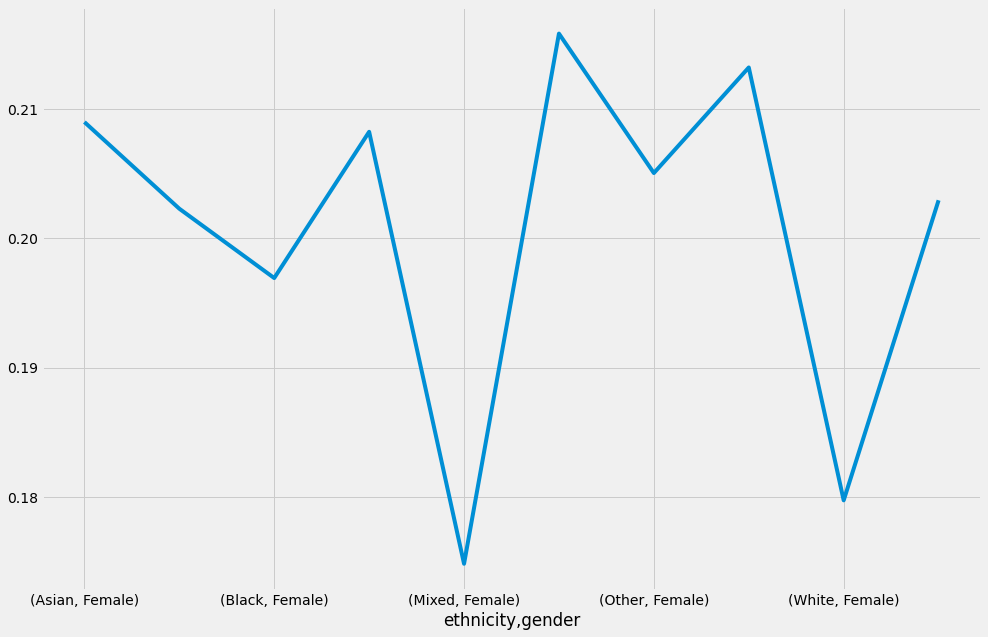

In [123]:
df_subscores.plot(figsize=(15,10))

In [75]:
df_subscores.dropna().agg(['mean', 'std'])#.unstack()

mean    0.196808
std     0.081252
dtype: float64

In [45]:
# logistic regression
pred_train = pipeline.predict(X_train)
pred_val = pipeline.predict(X_val)

pred_train = authorise_search(pipeline, X_train)
pred_val = authorise_search(pipeline, X_val)

score_train = precision_score(y_train, pred_train)
score_val = precision_score(y_val, pred_val)

print(score_train, score_val)

0.23476976895138713 0.23309774108610007


In [49]:
# tree
pred_train = authorise_search(pipeline, X_train)
pred_val = authorise_search(pipeline, X_val)

score_train = precision_score(y_train, pred_train)
score_val = precision_score(y_val, pred_val)

print(score_train, score_val)

0.9040430582990522 0.29598624710366994


In [57]:
# stochastic gradient descent
pred_train = authorise_search(pipeline, X_train)
pred_val = authorise_search(pipeline, X_val)

score_train = precision_score(y_train, pred_train)
score_val = precision_score(y_val, pred_val)

print(score_train, score_val)

0.2295369582468855 0.22824487299554672


In [69]:
# random forrest
pred_train = authorise_search(pipeline, X_train)
pred_val = authorise_search(pipeline, X_val)

score_train = precision_score(y_train, pred_train)
score_val = precision_score(y_val, pred_val)

print(score_train, score_val)

0.5267731750842106 0.2618030066871135


In [35]:
# XGB
pred_train = authorise_search(pipeline, X_train)
pred_val = authorise_search(pipeline, X_val)

score_train = precision_score(y_train, pred_train)
score_val = precision_score(y_val, pred_val)

print(score_train, score_val)

0.24838121995653986 0.24270587463939156


In [38]:
# LGBM
pred_train = authorise_search(pipeline, X_train)
pred_val = authorise_search(pipeline, X_val)

score_train = precision_score(y_train, pred_train)
score_val = precision_score(y_val, pred_val)

print(score_train, score_val)

0.24268189191221493 0.23942960833748173


In [41]:
# CatBoost
pred_train = authorise_search(pipeline, X_train)
pred_val = authorise_search(pipeline, X_val)

score_train = precision_score(y_train, pred_train)
score_val = precision_score(y_val, pred_val)

print(score_train, score_val)

0.2514887565549729 0.24520869001512607


In [49]:
# AdaBoost
pred_train = authorise_search(pipeline, X_train)
pred_val = authorise_search(pipeline, X_val)

score_train = precision_score(y_train, pred_train)
score_val = precision_score(y_val, pred_val)

print(score_train, score_val)

0.20147680689004124 0.20103452735031682


In [50]:
roc_auc_score(y_val, pred_val)

0.5

In [ ]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy of %s is %s"%(clf, acc))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix of %s is %s"%(clf, cm)

### Model

## Training

In [694]:
pipeline.fit(X, y)

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('categoricals',
                                                 ColumnTransformer(transformers=[('operation',
                                                                                  SimpleImputer(fill_value=False,
                                                                                                strategy='constant'),
                                                                                  ['operation']),
                                                                                 ('legislation',
                                                                                  Pipeline(steps=[('legislation_imputer',
                                                                                                   SimpleImputer(fill_value='unknown',
                                                                                                                 strategy='co

#### Evaluate

In [698]:
authorised = authorise_search(pipeline, X)

In [699]:
authorised2 = authorise_search(pipeline2, X)

In [700]:
authorised3 = authorise_search(pipeline3, X)

In [701]:
pd.Series(authorised).value_counts()/len(y)

False    0.772567
True     0.227433
dtype: float64

In [702]:
pd.Series(authorised2).value_counts()/len(y)

True     0.815759
False    0.184241
dtype: float64

In [703]:
pd.Series(authorised3).value_counts()/len(y)

True     0.836779
False    0.163221
dtype: float64

In [704]:
confusion_matrix(y, authorised)

array([[238965,   8066],
       [     3,  62283]])

In [705]:
confusion_matrix(y, authorised2)

array([[ 53850, 193181],
       [  3139,  59147]])

In [706]:
confusion_matrix(y, authorised3)

array([[ 47885, 199146],
       [  2602,  59684]])

In [712]:
recall_score(y, authorised)

0.9999518350833253

In [713]:
recall_score(y, authorised2)

0.949603442186045

In [714]:
recall_score(y, authorised3)

0.9582249622708152

In [715]:
classification_report(y, authorised, output_dict=True)

{'False': {'precision': 0.9999874460178769,
  'recall': 0.9673482275503884,
  'f1-score': 0.9833970851791876,
  'support': 247031},
 'True': {'precision': 0.8853430752391648,
  'recall': 0.9999518350833253,
  'f1-score': 0.9391638707731745,
  'support': 62286},
 'accuracy': 0.9739134932771235,
 'macro avg': {'precision': 0.9426652606285209,
  'recall': 0.9836500313168568,
  'f1-score': 0.961280477976181,
  'support': 309317},
 'weighted avg': {'precision': 0.9769019406032929,
  'recall': 0.9739134932771235,
  'f1-score': 0.974490009291044,
  'support': 309317}}

### Serialise

In [63]:
import json
import pickle
import joblib

In [64]:
# serialise
with open('../deploy/columns.json', 'w') as fh:
    json.dump(X.columns.tolist(), fh)
    
with open('../deploy/dtypes.pickle', 'wb') as fh:
    pickle.dump(X.dtypes, fh)
    
joblib.dump(pipeline, '../deploy/pipeline.pickle')

['../deploy/pipeline.pickle']